# Tree Based Model Exercise
## Key Points
### 1 - Simple classifier model example for decision tree, recursive partition algrithm visulization
### 2 - Measure of Impurity
### 3 - Bagging and Random Forest
### 4 - Boosting and Xgboost
### 5 - Hyper parameter tuning example - Grid Search

Import required Python packages.

In [1]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

import pydotplus
from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

no display found. Using non-interactive Agg backend


Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [12]:
# DATA = Path('.').resolve().parents[1] / 'Class3/treepractice'
    # parents larger, directory more board and closer to root directory.
    # data in server or S3 bracket might need path
# print(DATA)
# LOAN3000_CSV = DATA / 'loan3000.csv'
# LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'

In [2]:
LOAN3000_CSV = 'loan3000.csv'
LOAN_DATA_CSV = 'loan_data.csv.gz'

# Tree Models
## A simple tree with visulization
The package _scikit-learn_ has the class `DecisionTreeClassifier` to build a decision tree model. The function `plotDecisionTree` from the _dmba_ package can be used to visualize the tree. 

##### Fit the tree model

In [4]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.003,
                       random_state=1)

In [17]:
print(f'{loan_tree.feature_names_in_[0]} feature importance : {loan_tree.feature_importances_[0]}')
print(f'{loan_tree.feature_names_in_[1]} feature importance : {loan_tree.feature_importances_[1]}')

borrower_score feature importance : 0.7786274213010703
payment_inc_ratio feature importance : 0.2213725786989296


##### Use exisitng module from dmba package for visulization

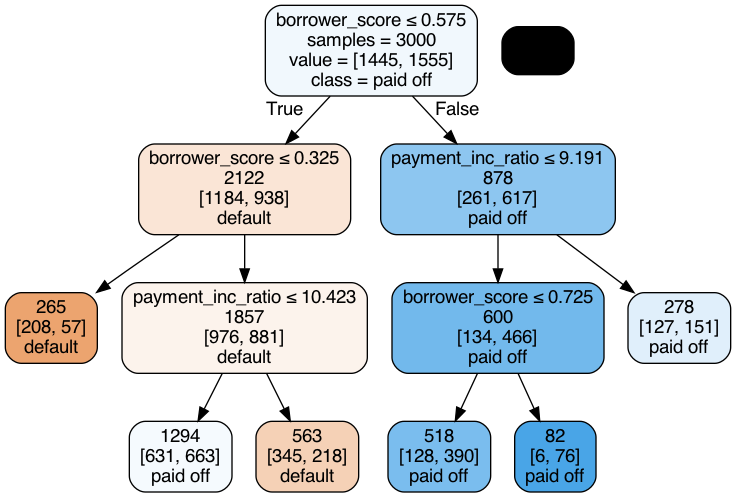

In [5]:
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

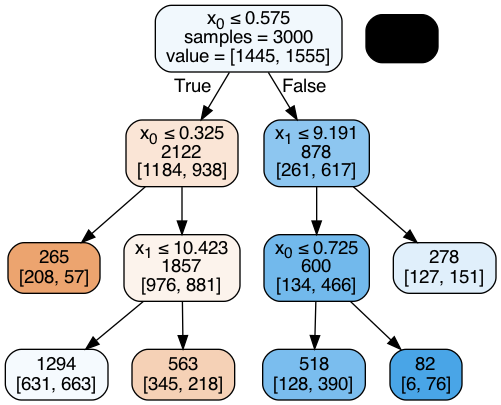

In [6]:
plotDecisionTree(loan_tree)

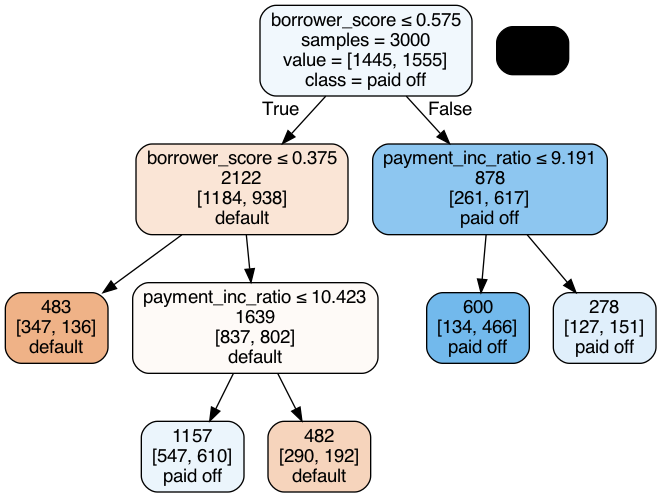

In [17]:
# use gini criterion (default)
loan_tree_1 = DecisionTreeClassifier(random_state=1,
                                   min_impurity_decrease=0.003)
loan_tree_1.fit(X, y)
plotDecisionTree(loan_tree_1, feature_names=predictors, class_names=loan_tree.classes_)

##### Use SKlearn module and image to visulize 

In [7]:
from sklearn import tree
from IPython.display import Image 

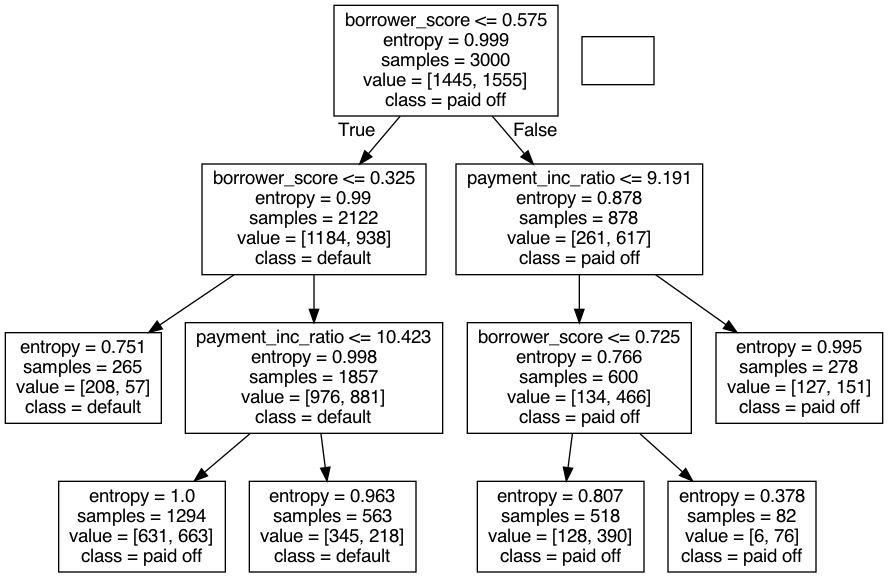

In [8]:
# Create DOT data
dot_data = tree.export_graphviz(loan_tree, out_file=None, 
                                feature_names=predictors,  
                                class_names=loan_tree.classes_)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

## Recursive Partitioning Algorithm and Tree example display the Algorithm
The data is repeatedly partitioned using predictor values which could do the best job of separating the data into relatively homogeneous partitions respect to target

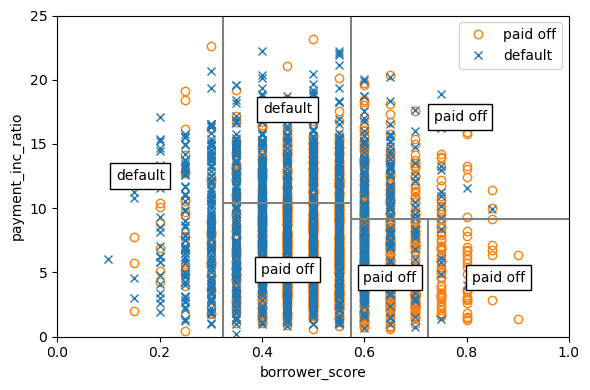

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)

loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='x', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)

ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325
y1b = 9.191
y2a = 10.423
x2b = 0.725

ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()

## Measuring Homogeneity or Impurity

In [18]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

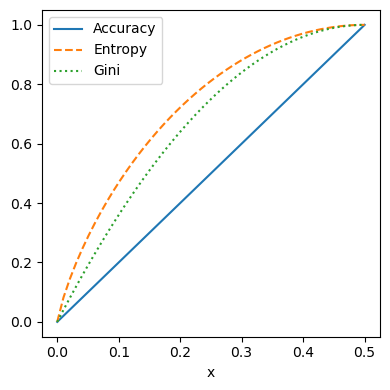

In [19]:
x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()

# Bagging and Random Forest
## Random Forest

#### Fit a simple random forest model

In [20]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, 
                            oob_score=True)
rf.fit(X, y)
print(rf.oob_decision_function_)
print(rf.oob_score_)

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]
0.5753333333333334


In [21]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rfc = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rfc.fit(X, y)
    oobScores.append(rfc.oob_score_)

<AxesSubplot: xlabel='n'>

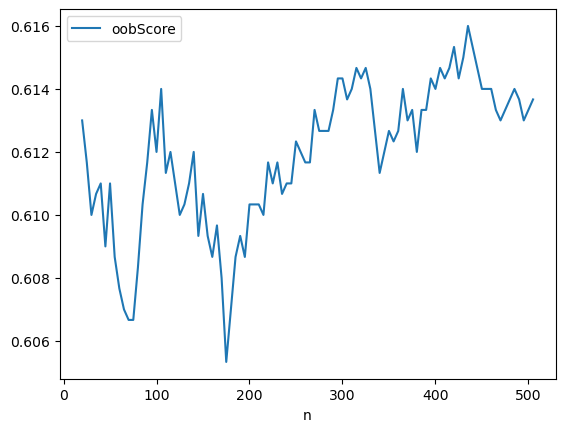

In [22]:
pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')

### Exercise 1 - oob, train, test score
1. Please recreate the above chart using testing dataset which created through train-test spliting
2. Please compare the result between OOB score and test score

In [43]:
# add validation score - would bs < training and validation 
n_estimator_test = list(range(20, 510, 5))
oobScores_test = []
test_score = []
train_score =[]

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

for n in n_estimator:
    rfc = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rfc.fit(train_X, train_y)
    # oobscore
    oobScores_test.append(rfc.oob_score_)
    # testing score
    score_test = metrics.f1_score(test_y, rfc.predict(test_X),pos_label='paid off')
    # training score
    score_train = metrics.f1_score(train_y, rfc.predict(train_X),pos_label='paid off')
    test_score.append(score_test)
    train_score.append(score_train)
    

    
score_sum = pd.DataFrame({
    'n': n_estimator_test, 
    'oobScore': oobScores_test,
    'test score': test_score,
    'train score': train_score 
})

In [44]:
score_sum

,n,oobScore,test score,train score
0,20,0.600833,0.639640,0.682740
1,25,0.601667,0.640364,0.669782
2,30,0.601667,0.640364,0.667708
3,35,0.605833,0.635945,0.666929
4,40,0.603750,0.635945,0.672387
...,...,...,...,...
93,485,0.605000,0.638365,0.665335
94,490,0.605833,0.637363,0.666401
95,495,0.605417,0.637500,0.667199
96,500,0.605417,0.636364,0.666667


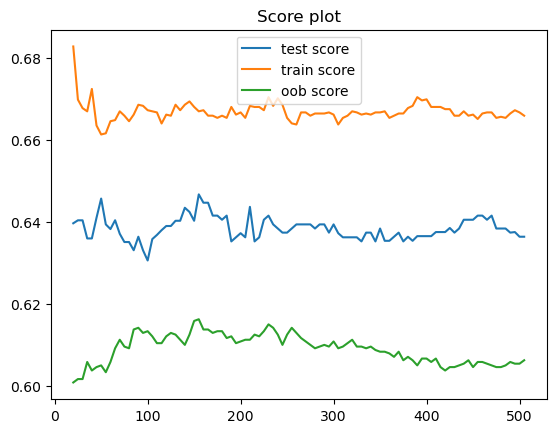

In [52]:
plt.plot(score_sum['n'], score_sum['test score'], label='test score')
plt.plot(score_sum['n'], score_sum['train score'],label='train score')
plt.plot(score_sum['n'], score_sum['oobScore'], label='oob score')

plt.title("Score plot")
 
plt.legend()
plt.show()

## Variable importance
This is different to R. The accuracy decrease is not available out of the box.

In [53]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

In [54]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=200, random_state=1)
rf_all.fit(X, y)
print(rf_all.fit(X, y))

RandomForestClassifier(n_estimators=200, random_state=1)


In [55]:
rf_all.feature_importances_

array([0.08013432, 0.09360235, 0.098726  , 0.10531536, 0.09446305,
       0.09763895, 0.01101562, 0.00870286, 0.06689884, 0.09724439,
       0.0525395 , 0.08742157, 0.02042316, 0.00745785, 0.0077043 ,
       0.00363248, 0.00133032, 0.00253928, 0.00166477, 0.00145783,
       0.00443181, 0.00324404, 0.00107487, 0.00179529, 0.00760575,
       0.0039356 , 0.0035425 , 0.00171182, 0.00493479, 0.00334755,
       0.00760961, 0.01341332, 0.00344028])

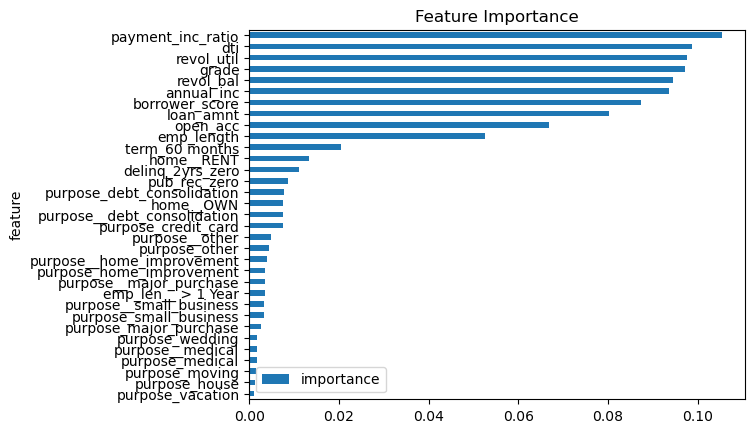

In [56]:
df = pd.DataFrame({
    'feature': X.columns, 
    'importance': rf_all.feature_importances_
})
df = df.sort_values('importance')

ax = df.plot(kind='barh', x='feature', y='importance', 
             title="Feature Importance")

plt.show()

# Boosting
### Use XGBoost as example algorithm

In [65]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'dv'

loan3000_2 = loan3000.copy()
loan3000_2['dv'] = [1 if out=="default" else 0 for out in loan3000_2['outcome']]

X = loan3000_2[predictors]
y = loan3000_2[outcome]

xgb = XGBClassifier(objective='binary:logistic', subsample=.63)
print(xgb.fit(X, y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [66]:
xgb_df = X.copy()
xgb_df['prediction'] = xgb.predict(X)
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

   borrower_score  payment_inc_ratio  prediction  prob_default
0            0.40            5.11135           0      0.828856
1            0.40            5.43165           1      0.260156
2            0.70            9.23003           1      0.320805
3            0.40            2.33482           0      0.678005
4            0.45           12.10320           1      0.140204


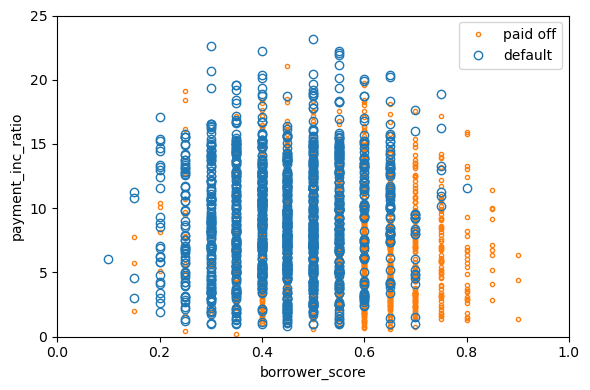

In [67]:
fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction==0].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction==1].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()

### Feature importance

xgboost supports different types of feature importance, you can specific which type to compute using the following code: https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

```
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

f = ‘gain’
XGBClassifier.get_booster().get_score(importance_type=f)
```

Default is usually `weight` (frequency) which may not be super helpful.

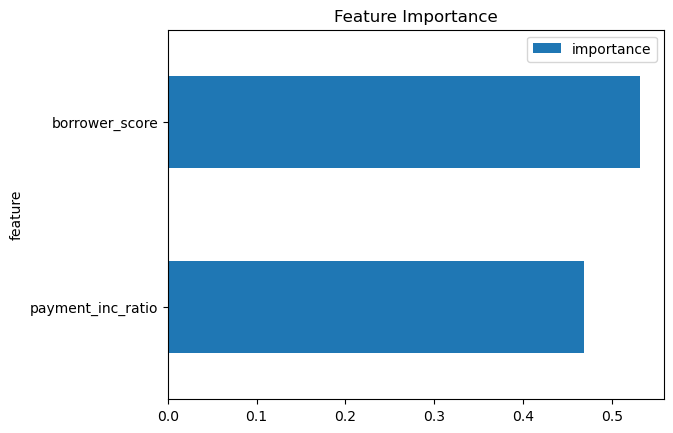

In [68]:
df = pd.DataFrame({
    'feature': X.columns, 
    'importance': xgb.feature_importances_
})
df = df.sort_values('importance')

ax = df.plot(kind='barh', x='feature', y='importance', 
             title="Feature Importance")

plt.show()

## Regularization: Avoiding Overfitting

In [69]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=0, learning_rate=0.3, subsample=1)
xgb_default.fit(train_X, train_y)

xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63, colsample_bytree=0.7)

print(xgb_penalty.fit(train_X, train_y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [70]:
pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

default (train):  0.11929149453907532
default:  0.3596
penalty:  0.3328


In [ ]:
results = []
for ntree_limit in range(1, 250):
    train_default = xgb_default.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    results.append({
        'iterations': ntree_limit,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

results = pd.DataFrame(results)
print(results.head())

<AxesSubplot:xlabel='iterations'>

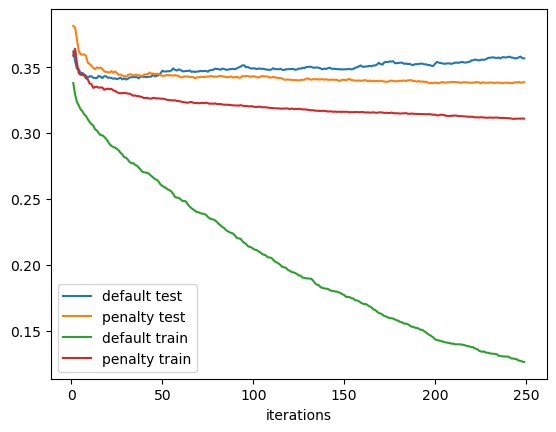

In [37]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)

## Hyperparameters and Cross-Validation

### Small scale grid search

#### Manual k-fold cross-validation

Note: this example code is using `average_error` which is usually not a very good classification metric (why?) 

You can practice changing it to a different metric for evaluation.

In [72]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]):
    xgb = XGBClassifier(
        objective='binary:logistic', 
        n_estimators=100, 
        max_depth=max_depth, 
        learning_rate=eta
    )
    
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.3303235776717017}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.33023765303044483}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.33858974973671746}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.333808253423475}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.35397516554080694}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.369259056567837}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.3421534483973325}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.37650213663262255}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.38762969349041787}
   eta  max_depth  avg_error
0  0.1          3   0.330324
1  0.1          6   0.330238
2  0.1          9   0.338590
3  0.5          3   0.333808
4  0.5          6   0.353975
5  0.5          9   0.369259
6  0.9          3   0.342153
7  0.9          6   0.376502
8  0.9          9   0.387630


In [73]:
print(errors.pivot_table(index='eta', columns='max_depth', values='avg_error') * 100)

max_depth          3          6          9
eta                                       
0.1        33.032358  33.023765  33.858975
0.5        33.380825  35.397517  36.925906
0.9        34.215345  37.650214  38.762969


#### Cross-validation using SKlearn pipeline

In this example we will use `roc_auc` as the cv metric

In [74]:
from sklearn.model_selection import GridSearchCV

In [75]:
# set up model
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
)

# set up parameter
parameters = {
    'eta' : [0.1, 0.5, 0.9],
    'max_depth' : [3, 6, 9],
}

# set up grid search cv
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5,
    verbose=True
)

In [77]:
grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.1, 0.5, 0.9], 'max_depth': [3, 6, 9]},
             scoring='roc_auc', verbose=True)

In [78]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              nthread=4, num_parallel_tree=None, ...)

In [79]:
mean_cv_score = grid_search.cv_results_['mean_test_score']
std_cv_score = grid_search.cv_results_['std_test_score']
params_comb = grid_search.cv_results_['params']

([<matplotlib.axis.XTick at 0x7fd9faeaff10>,
 [Text(0, 0, "{'eta': 0.1, 'max_depth': 3}"),
  Text(1, 0, "{'eta': 0.1, 'max_depth': 6}"),
  Text(2, 0, "{'eta': 0.1, 'max_depth': 9}"),
  Text(3, 0, "{'eta': 0.5, 'max_depth': 3}"),
  Text(4, 0, "{'eta': 0.5, 'max_depth': 6}"),
  Text(5, 0, "{'eta': 0.5, 'max_depth': 9}"),
  Text(6, 0, "{'eta': 0.9, 'max_depth': 3}"),
  Text(7, 0, "{'eta': 0.9, 'max_depth': 6}"),
  Text(8, 0, "{'eta': 0.9, 'max_depth': 9}")])

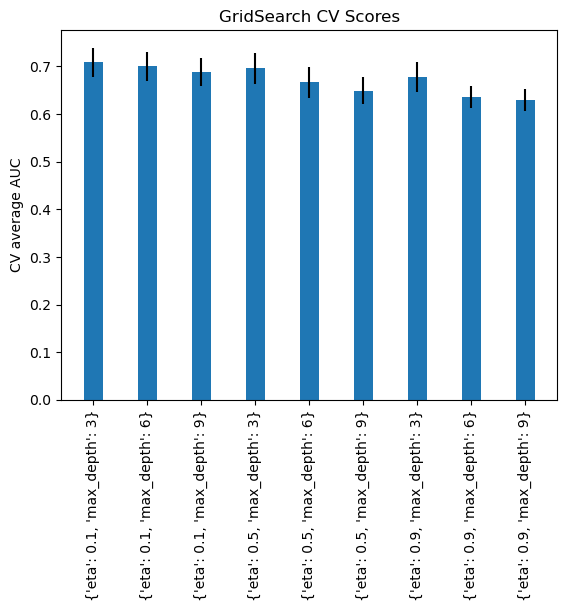

In [80]:
ind = np.arange(len(mean_cv_score))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

bars = plt.bar(ind, mean_cv_score, width, yerr=std_cv_score)
plt.ylabel('CV average AUC')
plt.title('GridSearch CV Scores')
plt.xticks(ind, params_comb, rotation='vertical')

### Exercise 2: 

parameters to tune: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Could you extend the grid serch to three or more parameters? 
- Yes. but graphs become ugly and very time-consuming

Could you extend parameter tuning to random search? (hint: sklearn has `RandomizedSearchCV`)
- Yes, much faster than grid search

grid search looks at every possible combination of hyperparameters to find the best model, random search only selects and tests a random combination of hyperparameters.

Fitting 5 folds for each of 81 candidates, totalling 405 fits


([<matplotlib.axis.XTick at 0x7fda5a179270>,
 [Text(0, 0, "{'alpha': 0.01, 'eta': 0.1, 'gamma': 0, 'max_depth': 3}"),
  Text(1, 0, "{'alpha': 0.01, 'eta': 0.1, 'gamma': 0, 'max_depth': 6}"),
  Text(2, 0, "{'alpha': 0.01, 'eta': 0.1, 'gamma': 0, 'max_depth': 9}"),
  Text(3, 0, "{'alpha': 0.01, 'eta': 0.1, 'gamma': 1, 'max_depth': 3}"),
  Text(4, 0, "{'alpha': 0.01, 'eta': 0.1, 'gamma': 1, 'max_depth': 6}"),
  Text(5, 0, "{'alpha': 0.01, 'eta': 0.1, 'gamma': 1, 'max_depth': 9}"),
  Text(6, 0, "{'alpha': 0.01, 'eta': 0.1, 'gamma': 2, 'max_depth': 3}"),
  Text(7, 0, "{'alpha': 0.01, 'eta': 0.1, 'gamma': 2, 'max_depth': 6}"),
  Text(8, 0, "{'alpha': 0.01, 'eta': 0.1, 'gamma': 2, 'max_depth': 9}"),
  Text(9, 0, "{'alpha': 0.01, 'eta': 0.5, 'gamma': 0, 'max_depth': 3}"),
  Text(10, 0, "{'alpha': 0.01, 'eta': 0.5, 'gamma': 0, 'max_depth': 6}"),
  Text(11, 0, "{'alpha': 0.01, 'eta': 0.5, 'gamma': 0, 'max_depth': 9}"),
  Text(12, 0, "{'alpha': 0.01, 'eta': 0.5, 'gamma': 1, 'max_depth': 3}"),
  T

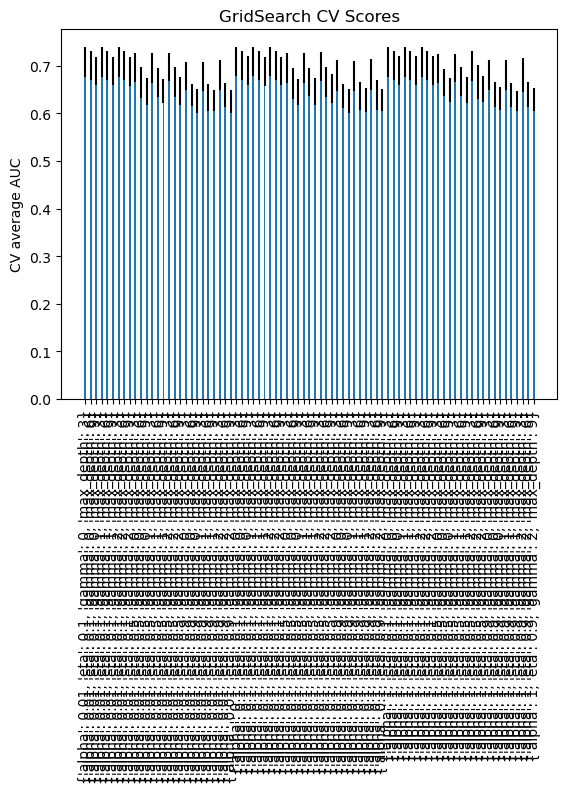

In [86]:
# set up model
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
)

# set up parameter
parameters = {
    'eta' : [0.1, 0.5, 0.9], # learning rate
    'max_depth' : [3, 6, 9],
    'alpha' : [0.01, 0.1, 1], # regularization
    'gamma' : [0, 1, 2] # minimum loss reduction to create new tree-split.
}

# set up grid search cv
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5,
    verbose=True
)

grid_search.fit(X, y)
grid_search.best_estimator_
mean_cv_score_grid = grid_search.cv_results_['mean_test_score']
std_cv_score_grid = grid_search.cv_results_['std_test_score']
params_comb_grid = grid_search.cv_results_['params']

# cv score
ind = np.arange(len(mean_cv_score_grid))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

bars = plt.bar(ind, mean_cv_score_grid, width, yerr=std_cv_score_grid)
plt.ylabel('CV average AUC')
plt.title('GridSearch CV Scores')
plt.xticks(ind, params_comb_grid, rotation='vertical')

In [87]:
mean_cv_score_grid
min(mean_cv_score_grid) 

0.6241822365654013

Fitting 5 folds for each of 10 candidates, totalling 50 fits


([<matplotlib.axis.XTick at 0x7fda280fa9e0>,
 [Text(0, 0, "{'max_depth': 3, 'gamma': 0, 'eta': 0.5, 'alpha': 1}"),
  Text(1, 0, "{'max_depth': 6, 'gamma': 2, 'eta': 0.9, 'alpha': 0.01}"),
  Text(2, 0, "{'max_depth': 9, 'gamma': 1, 'eta': 0.9, 'alpha': 0.1}"),
  Text(3, 0, "{'max_depth': 9, 'gamma': 0, 'eta': 0.9, 'alpha': 1}"),
  Text(4, 0, "{'max_depth': 3, 'gamma': 2, 'eta': 0.5, 'alpha': 0.01}"),
  Text(5, 0, "{'max_depth': 6, 'gamma': 0, 'eta': 0.5, 'alpha': 0.1}"),
  Text(6, 0, "{'max_depth': 6, 'gamma': 1, 'eta': 0.1, 'alpha': 0.1}"),
  Text(7, 0, "{'max_depth': 3, 'gamma': 1, 'eta': 0.1, 'alpha': 0.01}"),
  Text(8, 0, "{'max_depth': 3, 'gamma': 1, 'eta': 0.5, 'alpha': 0.01}"),
  Text(9, 0, "{'max_depth': 3, 'gamma': 2, 'eta': 0.1, 'alpha': 1}")])

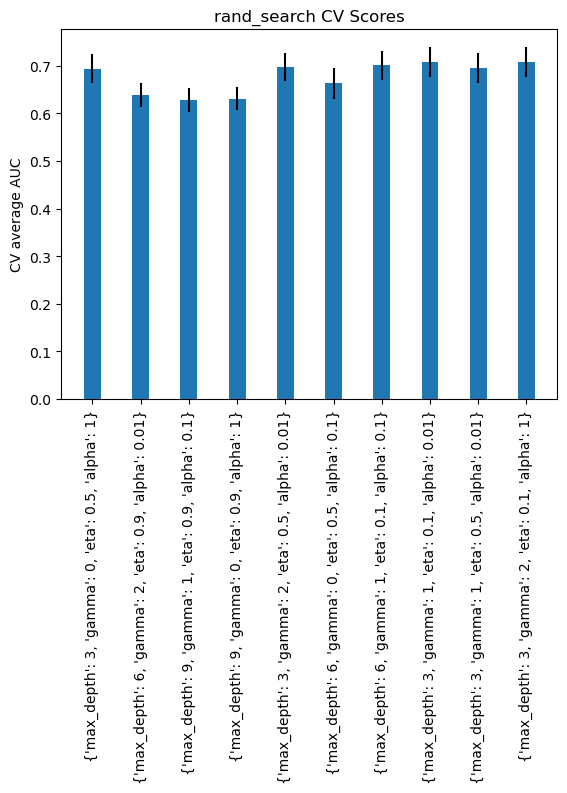

In [83]:
from sklearn.model_selection import RandomizedSearchCV

# set up model
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
)

# set up parameter
parameters = {
    'eta' : [0.1, 0.5, 0.9], # learning rate
    'max_depth' : [3, 6, 9],
    'alpha' : [0.01, 0.1, 1], # regularization
    'gamma' : [0, 1, 2] # minimum loss reduction to create new tree-split.
}

# set up grid search cv
rand_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5,
    verbose=True
)

rand_search.fit(X, y)
rand_search.best_estimator_
mean_cv_score = rand_search.cv_results_['mean_test_score']
std_cv_score = rand_search.cv_results_['std_test_score']
params_comb = rand_search.cv_results_['params']

# cv score
ind = np.arange(len(mean_cv_score))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

bars = plt.bar(ind, mean_cv_score, width, yerr=std_cv_score)
plt.ylabel('CV average AUC')
plt.title('rand_search CV Scores')
plt.xticks(ind, params_comb, rotation='vertical')

In [89]:
min(mean_cv_score) # random searh min

0.6281677847184042